# Differential drive robot (i.e., "segbot") in artificial gravity

# For results in a bumpy environment

1) Please click "restart and run all". Please refer to markdown plots to see which plots are relevant in a bumpy environment.

# For results in a non-bumpy environment

 1) Change "bumpy=True" to "bumpy=False" in the 2nd code cell. Restart and run all. Please refer to markdown plots to see which plots are relevant in a non-bumpy environment.

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the "latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_segbot)

<module 'ae353_segbot' from 'C:\\Users\\Alec\\Documents\\Junior_Year\\AE_353\\ae353-sp22\\projects\\02_segbot\\ae353_segbot.py'>

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `width` and `height` (positive integers, default `640` and `480`, respectively) is the weight and height of the simulation window (if shown) in pixels;
* `bumpy` (`True` or `False`) is whether or not the station is "bumpy".

**You must evaluate this cell only *once*.** If you want to start fresh with a new simulator, you must do `Kernel -> Restart` from the notebook menu first. If you evaluate this cell more than once without a call to `Kernel -> Restart` then you may get strange behavior that is hard to debug.

In [2]:
simulator = ae353_segbot.Simulator(
    display=True,
    width=480,
    height=320,
    bumpy=True,
)

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the gimbal. Modify the `run` function to make the controller behave differently.

# System of Equations

$\begin{bmatrix} \dot{e}_\text{lateral} \\ \dot{e}_\text{heading} \\ \dot{v} \\ \dot{w} \\ \ddot{\theta} \end{bmatrix}=
\begin{bmatrix}v \sin{\left(e_\text{heading} \right)}\\w\\- \frac{2400 \tau_{L} + 2400 \tau_{R} + 2808 \left(\dot{\theta}^{2} + w^{2}\right) \sin{\left(\theta \right)} + 65 \left(50 \tau_{L} + 50 \tau_{R} - 39 w^{2} \sin{\left(2 \theta \right)} - 900 \sin{\left(\theta \right)}\right) \cos{\left(\theta \right)}}{11700 \cos^{2}{\left(\theta \right)} - 12168}\\\frac{32 \left(- 875 \tau_{L} + 875 \tau_{R} - 1443 \dot{\theta} w \sin{\left(2 \theta \right)} - 2925 v w \sin{\left(\theta \right)}\right)}{13 \left(3120 \sin^{2}{\left(\theta \right)} + 2051\right)}\\\frac{5 \left(8450 \tau_{L} + 8450 \tau_{R} - 6591 w^{2} \sin{\left(2 \theta \right)} + 60 \left(100 \tau_{L} + 100 \tau_{R} + 117 \left(\dot{\theta}^{2} + w^{2}\right) \sin{\left(\theta \right)}\right) \cos{\left(\theta \right)} - 152100 \sin{\left(\theta \right)}\right)}{1404 \left(25 \cos^{2}{\left(\theta \right)} - 26\right)}\end{bmatrix}$

# Linearize

$f(x, u)=
\begin{bmatrix} \dot{e}_\text{lateral} \\ \dot{e}_\text{heading} \\ \dot{v} \\ \dot{w} \\ \dot{p} \\ \dot{\theta} \end{bmatrix}=
    \begin{bmatrix}v \sin{\left(e_\text{heading} \right)}\\w\\- \frac{2400 \tau_{L} + 2400 \tau_{R} + 2808 \left(p^{2} + w^{2}\right) \sin{\left(\theta \right)} + 65 \left(50 \tau_{L} + 50 \tau_{R} - 39 w^{2} \sin{\left(2 \theta \right)} - 900 \sin{\left(\theta \right)}\right) \cos{\left(\theta \right)}}{11700 \cos^{2}{\left(\theta \right)} - 12168}\\\frac{32 \left(- 875 \tau_{L} + 875 \tau_{R} - 1443 p w \sin{\left(2 \theta \right)} - 2925 v w \sin{\left(\theta \right)}\right)}{13 \left(3120 \sin^{2}{\left(\theta \right)} + 2051\right)}\\\frac{5 \left(8450 \tau_{L} + 8450 \tau_{R} - 6591 w^{2} \sin{\left(2 \theta \right)} + 60 \left(100 \tau_{L} + 100 \tau_{R} + 117 \left(p^{2} + w^{2}\right) \sin{\left(\theta \right)}\right) \cos{\left(\theta \right)} - 152100 \sin{\left(\theta \right)}\right)}{1404 \left(25 \cos^{2}{\left(\theta \right)} - 26\right)}\\ p\end{bmatrix}$

# Define Constants

In [3]:
import sympy as sym
from sympy.physics import mechanics
mechanics.init_vprinting()

# Dimensions of chassis
dx = 0.4
dy = 0.6
dz = 0.8

# Distance between axle and COM of chassis
h = 0.3

# Half-distance between wheels
a = 0.7 / 2

# Mass of chassis
mb = 12.

# MOI of chassis
Jbx = (mb / 12) * (dy**2 + dz**2)
Jby = (mb / 12) * (dx**2 + dz**2)
Jbz = (mb / 12) * (dx**2 + dy**2)

# Radius of each wheel
r = 0.325

# Width of each wheel
hw = 0.075

# Mass of each wheel
mw = 1.2

# MOI of each wheel
Jw = (mw / 2) * r**2
Jwt = (mw / 12) * (3 * r**2 + hw**2)

# Total mass
m = mb + 2 * mw

# Total MOI
Jx = Jbx + 2 * Jwt
Jy = Jby
Jz = Jbz + 2 * Jwt

# Station parameters
station_velocity = -0.5 # <-- FIXME (change the velocity to change gravity)
station_radius = 20.    # <-- radius in meters of inside surface of station

# Acceleration of artifical gravity
g = station_velocity**2 * station_radius

# Dimensions
h = sym.nsimplify(h)
a = sym.nsimplify(a)
r = sym.nsimplify(r)

# Masses
mb = sym.nsimplify(mb)
mw = sym.nsimplify(mw)
m = sym.nsimplify(m)

# MOIs
Jx = sym.nsimplify(Jx)
Jy = sym.nsimplify(Jy)
Jz = sym.nsimplify(Jz)
Jw = sym.nsimplify(Jw)
Jwt = sym.nsimplify(Jwt)

# Gravity
g = sym.nsimplify(g)

(e_l,
 e_h,
 v,
 w,
 theta,
 thetadot,
 tau_R,
 tau_L,
 p) = sym.symbols('e_l, e_h, v, w, theta, thetadot, tau_R, tau_L, p', real=True)

# Define system of equations symbolically

In [4]:
M = sym.Matrix([[m + 2 * Jw / r**2, 0, mb * h * sym.cos(theta)],
                [0, (Jx + mb * h**2) * sym.sin(theta)**2 + Jz * sym.cos(theta)**2 + (2 * Jw * a**2 / r**2) + 2 * mw * a**2, 0],
                [mb * h * sym.cos(theta), 0, Jy * mb * h**2]])
N = sym.Matrix([[mb * h * (w**2 + p**2) * sym.sin(theta)],
                [-2 * (Jx - Jz + m * h**2) * sym.cos(theta) * sym.sin(theta) * w * p - mb * h * sym.sin(theta) * v * w],
                [(Jx - Jz + mb * h**2) * sym.cos(theta) * sym.sin(theta) * w**2 + mb * g * h * sym.sin(theta)]])
R = sym.Matrix([[1 / r, 1 / r],
                [-a / r, a / r],
                [-1, -1]])
f = sym.simplify(M.inv() * (N + R * sym.Matrix([[tau_L], [tau_R]])))


f = sym.Matrix([[v * sym.sin(e_h)],
                [w],
                [f],
                [p]])

# Find A and B matrices

In [5]:
import scipy as sci
import scipy.linalg as sla

# equilibrium of ve = 1
f_num = sym.lambdify([e_l, e_h, v, w, p, theta, tau_R, tau_L], f)
e_le = 0.
e_he = 0.
ve = 1.0
we = 0.
pe = 0.
thetae = 0.
tau_Re = 0.
tau_Le = 0.
#print(f_num(e_le, e_he, ve, we, pe, thetae, tau_Re, tau_Le).tolist())


#Find A
A_num = sym.lambdify((e_l, e_h, v, w, p, theta, tau_R, tau_L), f.jacobian([e_l, e_h, v, w, p, theta]))
A = A_num(e_le, e_he, ve, we, pe, thetae, tau_Re, tau_Le).astype(float)

#Find B
B_num = sym.lambdify((e_l, e_h, v, w, p, theta, tau_R, tau_L), f.jacobian([tau_R, tau_L]))
B = B_num(e_le, e_he, ve, we, pe, thetae, tau_Re, tau_Le).astype(float)

# Find controllability matrix, check if it is full rank

In [6]:
#Find W
a = np.poly(A)[1:]
Accf = np.block([[-a], [np.eye(A.shape[1]-1), np.zeros((A.shape[1]-1, 1))]])
Bccf = np.block([[np.ones((B.shape[1]))], [np.zeros((A.shape[1]-1, B.shape[1]))]])

n = A.shape[0]

# Initialize W with its first column
W = B

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])

# Check if controllable system
print(A.shape)
print(np.linalg.matrix_rank(W))
# Check condition number, this is extra
print(np.linalg.cond(W))

(6, 6)
6
80626342.75533481


# Implement LQR to find optimal gain matrix

In [7]:
# Create lateral error weight
Q1 = (1 / (0.08))**2 

# Create heading error weight
Q2 = (1 / (np.pi/15))**2 

# Create forward speed weight
Q3 = 300.0

# Create turning rate weight
Q4 = (1 / (np.pi/10))**2 

# Create pitch weight
Q5 = (1/ (np.pi/100))**2

# Create pitch rate weight
Q6 = (1 / (np.pi/10))**2  

# Create error weight matrix Q
Q = np.diag([Q1, Q2, Q3, Q4, Q5, Q6])

# Create effort weight matrix R
R1 = 1.0
R2 = 1.0
R = np.diag([R1, R2])

#Solve for optimal gain matrix
P = sla.solve_continuous_are(A, B, Q, R)
K1 = np.linalg.inv(R) @  B.T @ P

print('Your optimal gain matrix is:\n')
print(K1)

# check eigenvalues to ensure asymptotic stabilty
F = A - B@K1
s = sla.eigvals(F)
print('\n The eigenvalues of your system are:\n')
print(s)

if (s.real < 0).all() == True:
    print('\n The eigenvalues of your system are all of negative real part, \
    \n therefore the closed-loop system is indeed asymptotically stable')
else:
    print('\n The eigenvalues of your system are NOT all of negative real part, please refine your Q and R weights')


Your optimal gain matrix is:

[[  8.83883476   8.71985963 -12.24744871   3.65643891 -25.58172437
  -41.78296632]
 [ -8.83883476  -8.71985963 -12.24744871  -3.65643891 -25.58172437
  -41.78296632]]

 The eigenvalues of your system are:

[-1.56362925e+00+1.2778921j  -1.56362925e+00-1.2778921j
 -4.55231916e+00+0.j         -2.33554975e+03+0.j
 -8.04419870e-01+0.68804474j -8.04419870e-01-0.68804474j]

 The eigenvalues of your system are all of negative real part,     
 therefore the closed-loop system is indeed asymptotically stable


# Create controller

In [8]:
class Controller:
    def __init__(self, K, e_l, e_h, v, w, p, theta, tau_R, tau_L ):
        self.K = K
        self.e_le = e_le
        self.e_he = e_he
        self.ve = ve
        self.we = we
        self.pe = pe
        self.thetae = thetae
        self.tau_Re = tau_Re
        self.tau_Le = tau_Le
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        x = np.array([
            lateral_error - e_le,
            heading_error - e_he,
            forward_speed - ve,
            turning_rate - we,
            pitch_angle - thetae,
            pitch_rate - pe
        ])
        
        #Find input
        u = -self.K @ x
    
        
        #Find actuator command
        tau1 = u[0]
        tau2 = u[1]
        
        wheel_torque1 = tau1
        wheel_torque2 = tau2
        
        return wheel_torque1, wheel_torque2
        
        
        
K = K1



# Create an instance of the controller.

In [9]:
controller = Controller(K, e_le, e_he, ve, we, pe, thetae, tau_Re, tau_Le)

# Reset and run the simulator with given initial conditions.

Choose a camera view from the following options:
* `camera_sideview()`
* `camera_backview()`
* `camera_wideview()`

In [10]:
simulator.reset(
    initial_speed=1.,
    initial_lateral_error=0,
    initial_heading_error=0,
    initial_pitch=0,
    station_velocity=-0.5,
)
controller.reset()
simulator.camera_wideview()
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=15.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

 # Plot the results for bumpy environment at $v_e = 1.0$. 
 
 # Ignore this plot if you are testing in non-bumpy environment

Your maximum lateral error is: 0.156 meters
Your maximum lateral error satisfies the base requirement


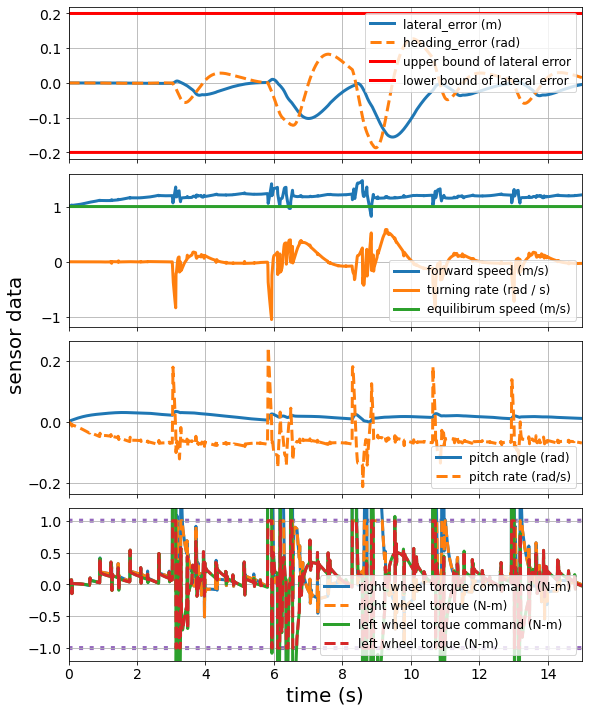

In [11]:
# Create a figure with four subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

fig.text(0, 0.53, 'sensor data', ha='center', va='center', rotation='vertical', fontsize=20)
# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=3,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=3,
)
ax_pos.plot(
    data['t'], 0.2* np.ones(1500),
    'r-', label='upper bound of lateral error', linewidth=3,
)
ax_pos.plot(
    data['t'], -0.2* np.ones(1500),
    'r-', label='lower bound of lateral error', linewidth=3,
)
ax_pos.grid()
ax_pos.legend(fontsize=12, loc='upper right')
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=3,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '-', label='turning rate (rad / s)', linewidth=3,
)

#comment me out
ax_vel.plot(
    data['t'], 1*np.ones(1500),
    '-', label='equilibirum speed (m/s)', linewidth=3,
)


ax_vel.grid()
ax_vel.legend(fontsize=12, loc='lower right')
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=3,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad/s)', linewidth=3,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=12, loc='lower right')
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=12, loc='lower right')
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

print('Your maximum lateral error is:', np.round(np.max(np.absolute(data['lateral_error'])), 3),'meters')
if np.max(np.absolute(data['lateral_error'])) < 0.2:
    print('Your maximum lateral error satisfies the base requirement')
else:
    print('Your maximum lateral error does not satisfy the base requirement')

# The following code is a copy of the code above, but slightly manipulated and housed in a single cell to plot the results for non-bumpy environment at $v_e = 1.7$ as shown in the report. 

# Ignore the produced plot if you are testing in a bumpy environment

(6, 6)
6
80626342.75533481
Your optimal gain matrix is:

[[  8.83883476  11.47011246 -12.24744871   3.99855896 -25.58172437
  -41.78296632]
 [ -8.83883476 -11.47011246 -12.24744871  -3.99855896 -25.58172437
  -41.78296632]]

 The eigenvalues of your system are:

[-1.84796806e+00+1.81564307j -1.84796806e+00-1.81564307j
 -4.70219243e+00+0.j         -2.33554975e+03+0.j
 -8.04419870e-01+0.68804474j -8.04419870e-01-0.68804474j]

 The eigenvalues of your system are all of negative real part,     
 therefore the closed-loop system is indeed asymptotically stable
Your maximum lateral error is: 0.44 meters
Your maximum lateral error does not satisfy the base requirement


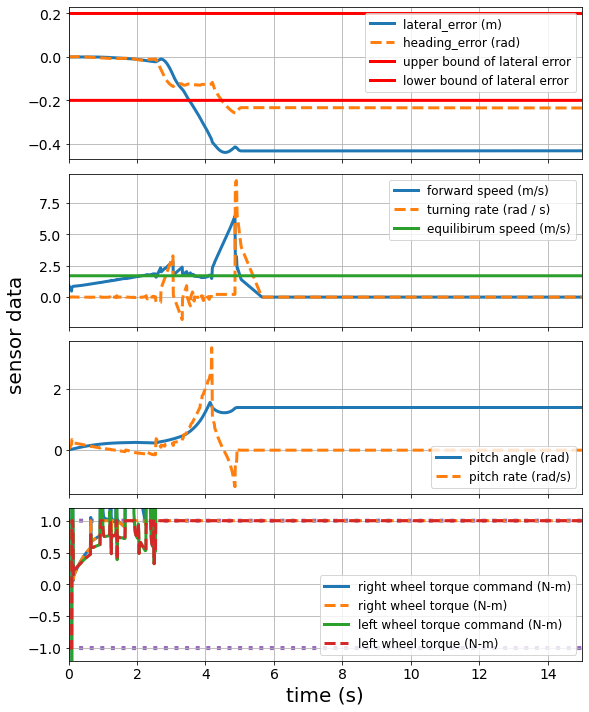

In [12]:
import scipy as sci
import scipy.linalg as sla

f_num = sym.lambdify([e_l, e_h, v, w, p, theta, tau_R, tau_L], f)
e_le = 0.
e_he = 0.
ve = 1.7
we = 0.
pe = 0.
thetae = 0.
tau_Re = 0.
tau_Le = 0.


#Find A
A_num = sym.lambdify((e_l, e_h, v, w, p, theta, tau_R, tau_L), f.jacobian([e_l, e_h, v, w, p, theta]))
A = A_num(e_le, e_he, ve, we, pe, thetae, tau_Re, tau_Le).astype(float)

#Find B
B_num = sym.lambdify((e_l, e_h, v, w, p, theta, tau_R, tau_L), f.jacobian([tau_R, tau_L]))
B = B_num(e_le, e_he, ve, we, pe, thetae, tau_Re, tau_Le).astype(float)


#Find W
a = np.poly(A)[1:]
Accf = np.block([[-a], [np.eye(A.shape[1]-1), np.zeros((A.shape[1]-1, 1))]])
Bccf = np.block([[np.ones((B.shape[1]))], [np.zeros((A.shape[1]-1, B.shape[1]))]])

n = A.shape[0]

# Initialize W with its first column
W = B

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])

# Check if controllable system
print(A.shape)
print(np.linalg.matrix_rank(W))
# Check condition number, this is extra
print(np.linalg.cond(W))

# Create lateral error weight
Q1 = (1 / (0.08))**2 

# Create heading error weight
Q2 = (1 / (np.pi/15))**2 

# Create forward speed weight
Q3 = 300.0

# Create turning rate weight
Q4 = (1 / (np.pi/10))**2 

# Create pitch weight
Q5 = (1/ (np.pi/100))**2

# Create pitch rate weight
Q6 = (1 / (np.pi/10))**2  

# Create error weight matrix Q
Q = np.diag([Q1, Q2, Q3, Q4, Q5, Q6])

# Create effort weight matrix R
R1 = 1.0
R2 = 1.0
R = np.diag([R1, R2])

#Solve for optimal gain matrix
P = sla.solve_continuous_are(A, B, Q, R)
K1 = np.linalg.inv(R) @  B.T @ P

print('Your optimal gain matrix is:\n')
print(K1)

# check eigenvalues to ensure asymptotic stabilty
F = A - B@K1
s = sla.eigvals(F)
print('\n The eigenvalues of your system are:\n')
print(s)

if (s.real < 0).all() == True:
    print('\n The eigenvalues of your system are all of negative real part, \
    \n therefore the closed-loop system is indeed asymptotically stable')
else:
    print('\n The eigenvalues of your system are NOT all of negative real part, please refine your Q and R weights')


class Controller:
    def __init__(self, K, e_l, e_h, v, w, p, theta, tau_R, tau_L ):
        self.K = K
        self.e_le = e_le
        self.e_he = e_he
        self.ve = ve
        self.we = we
        self.pe = pe
        self.thetae = thetae
        self.tau_Re = tau_Re
        self.tau_Le = tau_Le
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        x = np.array([
            lateral_error - e_le,
            heading_error - e_he,
            forward_speed - ve,
            turning_rate - we,
            pitch_angle - thetae,
            pitch_rate - pe
        ])
        
        #Find input
        u = -self.K @ x
    
        
        #Find actuator command
        tau1 = u[0]
        tau2 = u[1]
        
        wheel_torque1 = tau1
        wheel_torque2 = tau2
        
        return wheel_torque1, wheel_torque2
        
        
        
K = K1

controller = Controller(K, e_le, e_he, ve, we, pe, thetae, tau_Re, tau_Le)

simulator.reset(
    initial_speed=1.,
    initial_lateral_error=0,
    initial_heading_error=0,
    initial_pitch=0,
    station_velocity=-0.5,
)
controller.reset()
simulator.camera_backview()
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=15.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)



# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
fig.text(0, 0.53, 'sensor data', ha='center', va='center', rotation='vertical', fontsize=20)
# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=3,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=3,
)
ax_pos.plot(
    data['t'], 0.2* np.ones(1500),
    'r-', label='upper bound of lateral error', linewidth=3,
)
ax_pos.plot(
    data['t'], -0.2* np.ones(1500),
    'r-', label='lower bound of lateral error', linewidth=3,
)
ax_pos.grid()
ax_pos.legend(fontsize=12, loc='upper right')
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=3,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=3,
)
ax_vel.plot(
    data['t'], 1.7*np.ones(1500),
    '-', label='equilibirum speed (m/s)', linewidth=3,
)
ax_vel.grid()
ax_vel.legend(fontsize=12, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=3,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad/s)', linewidth=3,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=12, loc='lower right')
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=12, loc='lower right')
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

print('Your maximum lateral error is:', np.round(np.max(np.absolute(data['lateral_error'])), 3),'meters')
if np.max(np.absolute(data['lateral_error'])) < 0.2:
    print('Your maximum lateral error satisfies the base requirement')
else:
    print('Your maximum lateral error does not satisfy the base requirement')
    
fig.savefig('my_figure.png', facecolor='white', transparent=False)

# The following code is a copy of the code above, but slightly manipulated and housed in a single cell to plot the results for bumpy and non-bumpy environment at $v_e = 0.2$ as shown in the report.

(6, 6)
6
80626343.07215561
Your optimal gain matrix is:

[[  8.83883476   4.7258672  -12.24744871   3.09293812 -25.58172437
  -41.78296632]
 [ -8.83883476  -4.7258672  -12.24744871  -3.09293812 -25.58172437
  -41.78296632]]

 The eigenvalues of your system are:

[-4.45525232e+00+0.j         -5.64478820e-01+0.j
 -1.47633212e+00+0.j         -2.33554975e+03+0.j
 -8.04419870e-01+0.68804474j -8.04419870e-01-0.68804474j]

 The eigenvalues of your system are all of negative real part,     
 therefore the closed-loop system is indeed asymptotically stable
Your maximum lateral error is: 0.038 meters
Your maximum lateral error satisfies the base requirement


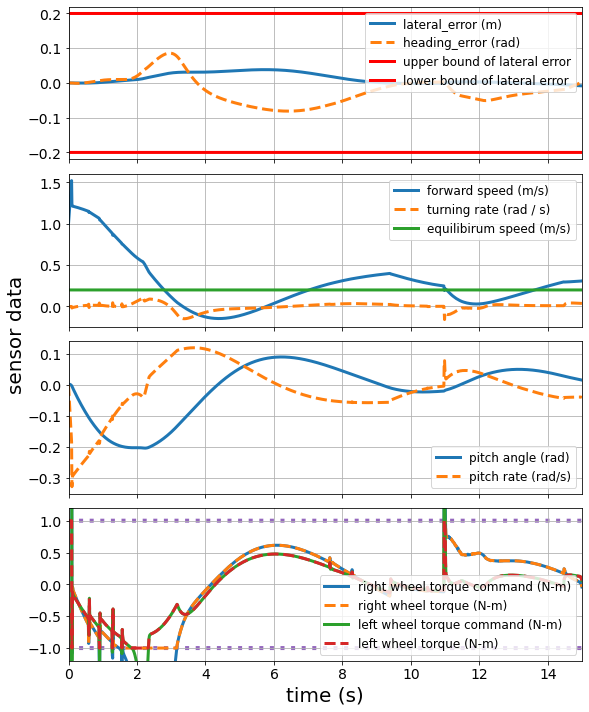

In [13]:
import scipy as sci
import scipy.linalg as sla

# equilibrium of ve = 0.2
f_num = sym.lambdify([e_l, e_h, v, w, p, theta, tau_R, tau_L], f)
e_le = 0.
e_he = 0.
ve = 0.2
we = 0.
pe = 0.
thetae = 0.
tau_Re = 0.
tau_Le = 0.
#print(f_num(e_le, e_he, ve, we, pe, thetae, tau_Re, tau_Le).tolist())


#Find A
A_num = sym.lambdify((e_l, e_h, v, w, p, theta, tau_R, tau_L), f.jacobian([e_l, e_h, v, w, p, theta]))
A = A_num(e_le, e_he, ve, we, pe, thetae, tau_Re, tau_Le).astype(float)

#Find B
B_num = sym.lambdify((e_l, e_h, v, w, p, theta, tau_R, tau_L), f.jacobian([tau_R, tau_L]))
B = B_num(e_le, e_he, ve, we, pe, thetae, tau_Re, tau_Le).astype(float)


#Find W
a = np.poly(A)[1:]
Accf = np.block([[-a], [np.eye(A.shape[1]-1), np.zeros((A.shape[1]-1, 1))]])
Bccf = np.block([[np.ones((B.shape[1]))], [np.zeros((A.shape[1]-1, B.shape[1]))]])

n = A.shape[0]

# Initialize W with its first column
W = B

# Create W one column at a time by iterating over i from 1 to n-1
for i in range(1, n):
    col = np.linalg.matrix_power(A, i) @ B
    W = np.block([W, col])

# Check if controllable system
print(A.shape)
print(np.linalg.matrix_rank(W))
# Check condition number, this is extra
print(np.linalg.cond(W))

# Create lateral error weight
Q1 = (1 / (0.08))**2 

# Create heading error weight
Q2 = (1 / (np.pi/15))**2 

# Create forward speed weight
Q3 = 300.0

# Create turning rate weight
Q4 = (1 / (np.pi/10))**2 

# Create pitch weight
Q5 = (1/ (np.pi/100))**2

# Create pitch rate weight
Q6 = (1 / (np.pi/10))**2  

# Create error weight matrix Q
Q = np.diag([Q1, Q2, Q3, Q4, Q5, Q6])

# Create effort weight matrix R
R1 = 1.0
R2 = 1.0
R = np.diag([R1, R2])

#Solve for optimal gain matrix
P = sla.solve_continuous_are(A, B, Q, R)
K1 = np.linalg.inv(R) @  B.T @ P

print('Your optimal gain matrix is:\n')
print(K1)

# check eigenvalues to ensure asymptotic stabilty
F = A - B@K1
s = sla.eigvals(F)
print('\n The eigenvalues of your system are:\n')
print(s)

if (s.real < 0).all() == True:
    print('\n The eigenvalues of your system are all of negative real part, \
    \n therefore the closed-loop system is indeed asymptotically stable')
else:
    print('\n The eigenvalues of your system are NOT all of negative real part, please refine your Q and R weights')


class Controller:
    def __init__(self, K, e_l, e_h, v, w, p, theta, tau_R, tau_L ):
        self.K = K
        self.e_le = e_le
        self.e_he = e_he
        self.ve = ve
        self.we = we
        self.pe = pe
        self.thetae = thetae
        self.tau_Re = tau_Re
        self.tau_Le = tau_Le
    def reset(self):
        pass
    
    def run(
            self,
            t,
            lateral_error,
            heading_error,
            forward_speed,
            turning_rate,
            pitch_angle,
            pitch_rate,
        ):
        
        x = np.array([
            lateral_error - e_le,
            heading_error - e_he,
            forward_speed - ve,
            turning_rate - we,
            pitch_angle - thetae,
            pitch_rate - pe
        ])
        
        #Find input
        u = -self.K @ x
    
        
        #Find actuator command
        tau1 = u[0]
        tau2 = u[1]
        
        wheel_torque1 = tau1
        wheel_torque2 = tau2
        
        return wheel_torque1, wheel_torque2
        
        
        
K = K1

controller = Controller(K, e_le, e_he, ve, we, pe, thetae, tau_Re, tau_Le)

simulator.reset(
    initial_speed=1.,
    initial_lateral_error=0,
    initial_heading_error=0,
    initial_pitch=0,
    station_velocity=-0.5,
)
controller.reset()
simulator.camera_backview()
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=15.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_pos, ax_vel, ax_pitch, ax_torque) = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
fig.text(0, 0.53, 'sensor data', ha='center', va='center', rotation='vertical', fontsize=20)
# Plot lateral and heading error
ax_pos.plot(
    data['t'], data['lateral_error'],
    label='lateral_error (m)', linewidth=3,
)
ax_pos.plot(
    data['t'], data['heading_error'],
    '--', label='heading_error (rad)', linewidth=3,
)
ax_pos.plot(
    data['t'], 0.2* np.ones(1500),
    'r-', label='upper bound of lateral error', linewidth=3,
)
ax_pos.plot(
    data['t'], -0.2* np.ones(1500),
    'r-', label='lower bound of lateral error', linewidth=3,
)
ax_pos.grid()
ax_pos.legend(fontsize=12, loc='upper right')
ax_pos.tick_params(labelsize=14)

# Plot forward speed and turning rate
ax_vel.plot(
    data['t'], data['forward_speed'],
    label='forward speed (m/s)', linewidth=3,
)
ax_vel.plot(
    data['t'], data['turning_rate'],
    '--', label='turning rate (rad / s)', linewidth=3,
)
ax_vel.plot(
    data['t'], 0.2*np.ones(1500),
    '-', label='equilibirum speed (m/s)', linewidth=3,
)
ax_vel.grid()
ax_vel.legend(fontsize=12, loc='upper right')
ax_vel.tick_params(labelsize=14)

# Plot pitch angle and pitch rate
ax_pitch.plot(
    data['t'], data['pitch_angle'],
    label='pitch angle (rad)', linewidth=3,
)
ax_pitch.plot(
    data['t'], data['pitch_rate'],
    '--', label='pitch rate (rad/s)', linewidth=3,
)
ax_pitch.grid()
ax_pitch.legend(fontsize=12, loc='lower right')
ax_pitch.tick_params(labelsize=14)

# Plot torques
ax_torque.plot(
    data['t'], data['right_wheel_torque_command'],
    label='right wheel torque command (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], data['right_wheel_torque'],
    '--', label='right wheel torque (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque_command'],
    label='left wheel torque command (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], data['left_wheel_torque'],
    '--', label='left wheel torque (N-m)', linewidth=3,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=12, loc='lower right')
ax_torque.tick_params(labelsize=14)
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

print('Your maximum lateral error is:', np.round(np.max(np.absolute(data['lateral_error'])), 3),'meters')
if np.max(np.absolute(data['lateral_error'])) < 0.2:
    print('Your maximum lateral error satisfies the base requirement')
else:
    print('Your maximum lateral error does not satisfy the base requirement')
    
fig.savefig('my_figure.png', facecolor='white', transparent=False)